# CS-E-106: Data Modeling
## Fall 2019: HW 08

### Important References and Links

*1. OLS Results stats (this has most of the stat tests required for regression diagnostics):*

https://www.statsmodels.org/stable/stats.html#module-statsmodels.stats.outliers_influence

*2. OLS Outlier Influence*

https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html

In [90]:
# ! pip install mlxtend

In [91]:
import numpy as np
import os
import pandas as pd
from scipy import stats
import time
import random
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import gofplots
import pylab
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Utility Functions

In [92]:
def scale_numeric(fit_df, trans_df, cols):
    df_scaled = trans_df[cols].copy()
    scaler = StandardScaler().fit(fit_df[cols])
    df_scaled = pd.DataFrame(scaler.transform(df_scaled), index=df_scaled.index, columns=cols)
    return(df_scaled)

def scale_encode(fit_df, trans_df, scale_num=True):
    num_cols = list(fit_df.columns[(fit_df.dtypes == 'float64') | (fit_df.dtypes == 'int64')])
    str_cols = list(set(fit_df.columns)^set(num_cols))

    if (len(num_cols)>0) & (len(str_cols)>0):
        if scale_num:
            df_scaled = scale_numeric(fit_df=fit_df, trans_df=trans_df, cols=num_cols)
        else:
            df_scaled = trans_df[num_cols].copy()
        df_dummy = pd.get_dummies(trans_df[str_cols])
        df =  df_scaled.join(df_dummy)
    elif len(str_cols)>0:
        df = pd.get_dummies(trans_df[str_cols])
    elif len(num_cols)>0:
        if scale_num:
            df = scale_numeric(fit_df=fit_df, trans_df=trans_df, cols=num_cols)
        else:
            df = trans_df[num_cols].copy()
    else:
        df = trans_df.copy()
    
    return(df)

**Question 1** Refer to Brand preference data, build a model with all independent variables (45 pts)

**(a)**	Obtain the studentized deleted residuals and identify any outlying Y observations. Use the Bonferroni outlier test procedure with α = .10. State the decision rule and conclusion. (5pts)

**Solution:**

In [93]:
brand_data = pd.read_csv("data/Brand Preference.csv")
lm_brand = ols("Y~X1+X2", data=brand_data).fit()
lm_brand.summary()

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     129.1
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           2.66e-09
Time:                        22:57:11   Log-Likelihood:                -36.894
No. Observations:                  16   AIC:                             79.79
Df Residuals:                      13   BIC:                             82.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.6500      2.996     12.566      0.000      31.177      44.123
X1             4.4250      0.301     14.695      0.000       3.774       5.076
X2             4.3750      0.673      6.498      0.000       2.920       5.830
==============================================================================
Omnibus:                        0.766   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.682   Jarque-Bera (JB):                0.647
Skew:                           0.049   Prob(JB):                        0.724
Kurtosis:                       2.020   Cond. No.                         35.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Studentized deleted residuals:*

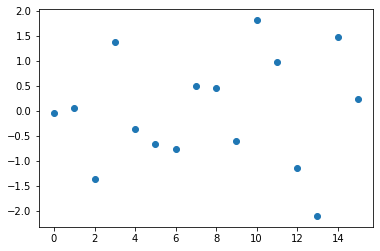

In [94]:
student_del_resids = OLSInfluence(lm_brand).resid_studentized_external
plt.scatter(student_del_resids.index, student_del_resids)

In [95]:
student_del_resids

0    -0.040855
1     0.061288
2    -1.360599
3     1.386025
4    -0.366946
5    -0.664906
6    -0.767162
7     0.504613
8     0.465067
9    -0.604363
10    1.823020
11    0.977843
12   -1.139664
13   -2.102726
14    1.489732
15    0.245729
dtype: float64

*Interpretation*

We can see that case 14 is an outlier with regard to the Y observations, based on the studentized deleted residuals.

*Bonferroni Outlier Test:*

$H_0:$ No outlier
$H_1:$ Atleast one outlier

In [96]:
n = brand_data.shape[0]
p = len(lm_brand.params)
alpha = 0.1
tTest = stats.t.ppf(1-alpha/(2*n), n-p-1)
tTest

3.307782648958124

In [97]:
which = np.abs(student_del_resids)>=np.abs(tTest)
which[which==True]

Series([], dtype: bool)

*Decision Rule:*

- If $|t_i| \leq t(1-\alpha/2n; n-p-1)$, $n=i$ is not an outlier.
- If $|t_i| > t(1-\alpha/2n; n-p-1)$, $n=i$ is an outlier.

*Result:*

Since none $|t_i| > t(1-\alpha/2n; n-p-1)$, we conclude $H_0$. There are no outliers with $\alpha=0.1$.


**(b)** Obtain the diagonal elements of the hat matrix, and provide an explanation for the pattern in these elements. (5pts)

**Solution:**

In [98]:
hii = OLSInfluence(lm_brand).summary_frame()["hat_diag"]
index = hii>2*p/n
index

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
Name: hat_diag, dtype: bool

*Interpretation:*

The hat matrix measures the distance between $X_i$ and $\bar{X}$. The fact that none of the $h_{ii}>\frac{2*p}{n}$ means that all the $X_i$s are more or less close to their means.

**(c)** Are any of the observations outlying with regard to their X values according? (5pts)

**Solution:**

We do not see any observations that are outliers with regard to their X values.

**(d)** Management wishes to estimate the mean degree of brand liking for moisture content X1 = 10 and sweetness X2 = 3. Construct a scatter plot of X2 against X1 and determine visually whether this prediction involves an extrapolation beyond the range of the data. Also, use (10.29) to determine whether an extrapolation is involved. Do your conclusions from the two methods agree? (5pts)

**Solution:**

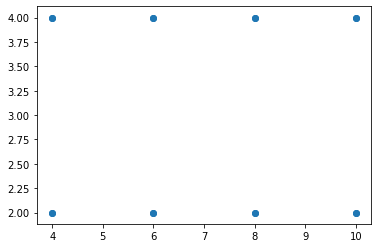

In [99]:
plt.scatter(brand_data["X1"], brand_data["X2"])

*Interpretation:*

We can see that $X_{1new}$ and $X_{2new}$ are both well within the range of the given dataset, so we don't need any extrapolation beyond the range of the data already given to us.

In [100]:
X_0 = np.ones(brand_data[["X1", "X2"]].shape[0]).reshape(-1,1)
X = np.matrix(np.hstack((X_0, brand_data[["X1", "X2"]])))
X

matrix([[ 1.,  4.,  2.],
        [ 1.,  4.,  4.],
        [ 1.,  4.,  2.],
        [ 1.,  4.,  4.],
        [ 1.,  6.,  2.],
        [ 1.,  6.,  4.],
        [ 1.,  6.,  2.],
        [ 1.,  6.,  4.],
        [ 1.,  8.,  2.],
        [ 1.,  8.,  4.],
        [ 1.,  8.,  2.],
        [ 1.,  8.,  4.],
        [ 1., 10.,  2.],
        [ 1., 10.,  4.],
        [ 1., 10.,  2.],
        [ 1., 10.,  4.]])

In [101]:
X_T = X.T
XTX = X_T * X
XTX_inv = XTX.I
XTX_inv

matrix([[ 1.23750000e+00, -8.75000000e-02, -1.87500000e-01],
        [-8.75000000e-02,  1.25000000e-02,  1.13335267e-17],
        [-1.87500000e-01, -3.96508223e-18,  6.25000000e-02]])

In [102]:
Xh = np.matrix([1,10,3])
H_extrap = Xh * XTX_inv * Xh.T
H_extrap

matrix([[0.175]])

In [103]:
np.min(hii), np.max(hii)

(0.13749999999999987, 0.23750000000000046)

Thus, we see that $h_{new.new}=0.175$

*Interpretation:*

From the above result, we see the value of $h_{new.new}$ is well within the range of the leverage values $h_{ii}$ for the cases in the data set, so no hidden extrapolation is involved for this estimate.

**(e)** The largest absolute studentized deleted residual is for case 14. Obtain the DFFlTS, DFBETAS, and Cook's distance values for this case to assess the influence of this case. What do you conclude? (5pts)

**Solution:**

In [104]:
influence_results = OLSInfluence(lm_brand).summary_frame()
influence_results.iloc[13,]

dfb_Intercept      0.838807
dfb_X1            -0.807680
dfb_X2            -0.602009
cooks_d            0.363412
standard_resid    -1.870891
hat_diag           0.237500
dffits_internal   -1.044144
student_resid     -2.102726
dffits            -1.173531
Name: 13, dtype: float64

*Interpretation:*

|DFBETAS| are all < 1, so case 14 does not have a big influence on betas.
|DFFITS| > 1, so case 14 has considerable influence on $Y_{14}$.
According to Cook's Distance, case 14 has little influence on all the fitted values, since $0.1<P(F(p, n-p) \leq Cook's Distance)<0.5$.

**(f)** Calculate the average absolute percent difference in the fitted values with and without case 14. What does this measure indicate about the influence of case 14? (10pts)

**Solution:**

In [105]:
new_df = brand_data.drop(brand_data.index[13])
new_lm_brand = ols("Y~X1+X2", data=new_df).fit()

fitted_new = new_lm_brand.fittedvalues
fitted_old = lm_brand.fittedvalues

newer_result = np.mean(np.abs(fitted_new-fitted_old)/fitted_old)
newer_new_result = (100*newer_result)/brand_data.shape[0]
print(newer_new_result)

0.03943374540066705


*Interpretation:*

We see that the measure indicated that case 14 has a big influence on the fitted regression function in the range of X observations directly.

**(g)** Calculate Cook's distance D; for each case and prepare an index plot. Are any cases influential according to this measure? (5pts)

**Solution:**

In [106]:
cooks_d = OLSInfluence(lm_brand).summary_frame()["cooks_d"]

<BarContainer object of 16 artists>

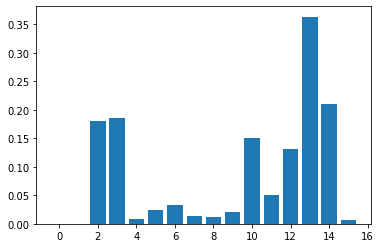

In [107]:
plt.bar(cooks_d.index, cooks_d)

*Interpretation:*

Cases 14 (Cook's Distance Value: 0.3634123447) and 15 (Cook's Distance Value: 0.2106609008) seem to be more influential compared to the others.

**(h)** Find the two variance inflation factors. Why are they both equal to 1? (5pts)

**Solution:**

In [138]:
X_cols = list(lm_brand.params.index)[1:]
X = sm.add_constant(brand_data[X_cols])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
                index=X.columns)
print(vif)

const    19.8
X1        1.0
X2        1.0
dtype: float64


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


*Interpretation:*

$(VIF)_k=(1-R_k^2)^{-1}$

Thus, all VIFs = 1 implies that there is no linear association between either Xs.

**Question 2** Refer to the Lung pressure Data and Homework 7. The subset regression model containing first-order terms for X1 and X2 and the cross-product term X1X2 is to be evaluated in detail. (35 pts)

**(a)** Obtain the residuals and plot them separately against Y and each of the three predictor variables. On the basis of these plots. should any further modification of the regression model be attempted? (5pts)

**Solution:**

In [109]:
lung_data = pd.read_csv("data/Lung Pressure.csv")
lung_data["X1X2"] = lung_data["X1"]*lung_data["X2"]
lm_lung = ols("Y~X1+X2+X1X2", data=lung_data).fit()
lm_lung.summary()

/home/srk-apts/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     19.06
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           2.23e-05
Time:                        22:57:21   Log-Likelihood:                -69.543
No. Observations:                  19   AIC:                             147.1
Df Residuals:                      15   BIC:                             150.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    134.3999     15.982      8.410      0.000     100.336     168.464
X1            -2.1330      0.522     -4.085      0.001      -3.246      -1.020
X2            -1.6993      0.364     -4.673      0.000      -2.474      -0.924
X1X2           0.0333      0.009      3.592      0.003       0.014       0.053
==============================================================================
Omnibus:                        4.466   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                2.559
Skew:                           0.868   Prob(JB):                        0.278
Kurtosis:                       3.466   Cond. No.                     1.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

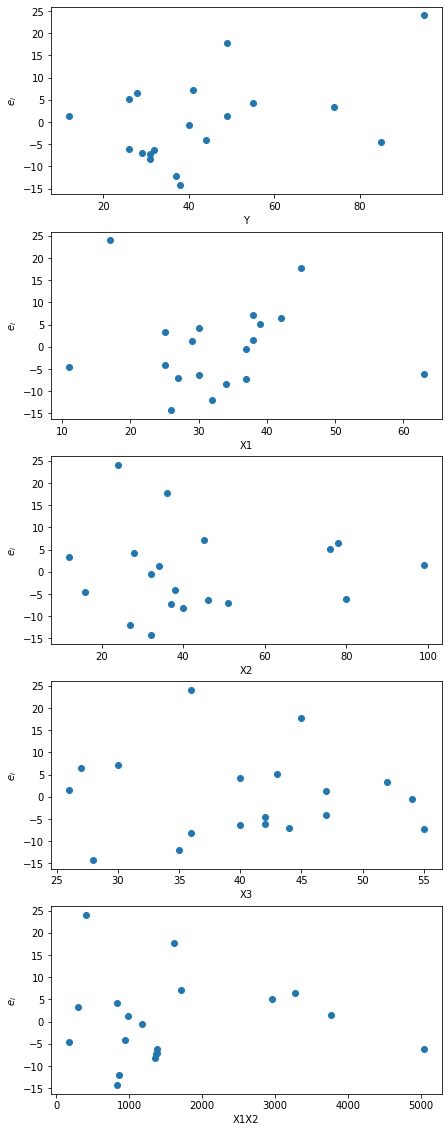

In [110]:
var = list(lung_data.columns)
ei = lm_lung.resid

fig, ax = plt.subplots(len(var), 1, figsize=(7,20))

for i in range(len(var)):
    ax[i].scatter(lung_data[var[i]], ei)
    ax[i].set_xlabel(var[i])
    ax[i].set_ylabel("$e_i$")

*Interpretation:*

We see that the plots dont have much pattern. However, we do see some outliers for X1 and the plot for the interaction term X1X2 seems to have non-constant error. 

**(b)** Prepare a normal probability plot of the residuals. Also obtain the coefficient of correlation between the ordered residuals and their expected values under normality. Does the normality assumption appear to be reasonable here? (5pts)

**Solution:**

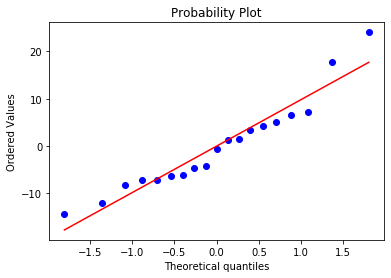

In [111]:
stats.probplot(lm_lung.resid, dist="norm", plot=pylab)
pylab.show()

*Interpretation:*

We can see that the plot is not linear and the residuals do not conform with the assumptions of normality.

**(c)** Obtain the variance inflation factors. Are there any indications that serious multicollinearity problems are present? Explain. (5pts)

**Solution:**

In [137]:
X_cols = list(lm_lung.params.index)[1:]
X = sm.add_constant(lung_data[X_cols])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
                index=X.columns)
print(vif)

const    43.316752
X1        5.431477
X2       11.639560
X1X2     22.474469
dtype: float64


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


*Interpretation:*

Since the variance inflation factors for all the coefficients in the model are $>1$, we can say that there is serious multi-collinearity present. 

**(d)** Obtain the studentized deleted residuals and identify outlying Y observations. Use the Bonferroni outlier test procedure with α= .05. State the decision rule and conclusion. (5pts)

**Solution:**


*Studentized deleted residuals:*

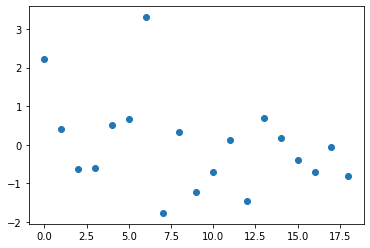

In [113]:
student_del_resids = OLSInfluence(lm_lung).resid_studentized_external
plt.scatter(student_del_resids.index, student_del_resids)

*Bonferroni Outlier Test:*

Test value = $t(1-\alpha/2n; n-p-1)$

$H_0:$ No outlier
$H_1:$ Atleast one outlier

In [114]:
n = lung_data.shape[0]
p = len(lm_lung.params)
alpha = 0.1
tTest = stats.t.ppf(1-alpha/(2*n), n-p-1)
tTest

3.299916688217126

In [115]:
which = np.abs(student_del_resids)>=np.abs(tTest)
which[which==True]

6    True
dtype: bool

*Decision Rule:*

- If $|t_i| \leq t(1-\alpha/2n; n-p-1)$, $n=i$ is not an outlier.
- If $|t_i| > t(1-\alpha/2n; n-p-1)$, $n=i$ is an outlier.

*Result:*

We can see that $|t_i| > t(1-\alpha/2n; n-p-1)$ for case #7, we conclude $H_1$ for that case. Case #7 is an outlier.

**(e)** Obtain the diagonal elell1ents of the hat matrix. Are there any outlying X observations? Discuss. (5pts)

**Solution:**

In [118]:
hii = OLSInfluence(lm_lung).summary_frame()["hat_diag"]
index = hii>2*p/n
index[index==True]

2     True
7     True
14    True
Name: hat_diag, dtype: bool


*Interpretation:*

The hat matrix measures the distance between $X_i$ and $\bar{X}$. We see that there are quite a few outlying X observations.

**(f)** Cases 3, 8, and 15 are moderately far outlying with respect to their X values, and case 7 is relatively far outlying with respect to its Y value. Obtain DFFITS, DFBETAS, and Cook's distance values for these cases to assess their inf1uence. What do you conclude? (10pts)

**Solution:**

In [119]:
influence_results = OLSInfluence(lm_lung).summary_frame()
influence_results

,dfb_Intercept,dfb_X1,dfb_X2,dfb_X1X2,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.747205,1.086986,0.223925,-0.595508,0.369041,1.969321,0.275692,1.214975,2.209498,1.363153
1,0.007215,0.030375,-0.005937,-0.020908,0.003833,0.410561,0.083370,0.123818,0.398887,0.120298
2,-0.651937,0.591913,0.433372,-0.481911,0.120516,-0.642279,0.538867,-0.694307,-0.629213,-0.680182
3,0.040625,-0.040524,-0.105923,0.092873,0.008854,-0.618137,0.084829,-0.188194,-0.604931,-0.184174
4,-0.048720,-0.000561,0.108881,-0.042167,0.014982,0.530316,0.175658,0.244802,0.517205,0.238750
5,-0.027644,-0.026282,0.071947,0.010397,0.023920,0.674533,0.173748,0.309319,0.661775,0.303468
6,1.454131,-1.277609,-0.741520,0.847523,0.458917,2.567968,0.217751,1.354868,3.314139,1.748551
7,-1.546908,1.186623,3.162265,-3.285790,4.990815,-1.663347,0.878279,-4.468026,-1.779408,-4.779785
8,0.102085,-0.046089,-0.105090,0.070106,0.007236,0.348387,0.192546,0.170126,0.337944,0.165026
9,0.035880,-0.171698,0.009243,0.101652,0.040999,-1.203490,0.101710,-0.404965,-1.223238,-0.411610


In [120]:
cases = [2,6,7,14]

influence_results.iloc[cases]

,dfb_Intercept,dfb_X1,dfb_X2,dfb_X1X2,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
2,-0.651937,0.591913,0.433372,-0.481911,0.120516,-0.642279,0.538867,-0.694307,-0.629213,-0.680182
6,1.454131,-1.277609,-0.741520,0.847523,0.458917,2.567968,0.217751,1.354868,3.314139,1.748551
7,-1.546908,1.186623,3.162265,-3.285790,4.990815,-1.663347,0.878279,-4.468026,-1.779408,-4.779785
14,-0.015506,-0.035251,0.077147,-0.015700,0.008170,0.188230,0.479821,0.180781,0.182063,0.174857


*Interpretation:*

*Case #3:* 

|DFFITS|<1 implies that this case does not have significant influence on $Y_3$.

|DFBETAS|<1 which implies this case does not have significant influence on the coefficients.

Cook Distance: According to Cook's Distance, this case has little influence on all the fitted values, since $0.1<P(F(p, n-p) \leq Cook's Distance)<0.5$.

*Case #7:*

|DFFITS|>1 implies that this case does have significant influence on $Y_7$.

|DFBETAS|>1 for $\beta_1$ only and remaining |DFBETAS|<1. Which implies this case only has significant influence on $\beta_1$ the coefficients.

Cook Distance: According to Cook's Distance, this case has little influence on all the fitted values, since $0.1<P(F(p, n-p) \leq Cook's Distance)<0.5$.

*Case #8:*

|DFFITS|>1 implies that this case does have significant influence on $Y_8$.

|DFBETAS|>1 for all variables. Which implies this case has significant influence on all the coefficients.

Cook Distance: According to Cook's Distance, this case has major influence on all the fitted values, since $P(F(p, n-p) \leq Cook's Distance)>0.5$.

*Case #15:*

|DFFITS|<1 implies that this case does not have significant influence on $Y_{15}$.

|DFBETAS|<1 for all variables. Which implies this case does not have significant influence on any of the coefficients.

Cook Distance: According to Cook's Distance, this case has no influence on all the fitted values, since $P(F(p, n-p) \leq Cook's Distance)<0.1$.


*Summary:*
- Case #8 seems to be the biggest outlier compared to other cases seen above.
- Case #7 has an impact only on $\beta_1$, which means that only $X_7$ might the outlier here.
- Case #3 and #15 don't seem to have much influence on the model and should not be consedered as outliers.


**Question 3** Refer to the Prostate Cancer data set in Appendix C.6 and Homework 7. For the best subset model developed in Homework 7, perform appropriate diagnostic checks to evaluate outliers and assess their influence. Do any serious multicollinearity problems exist here? (20pts)

**Solution:**

In [121]:
prostate_data = pd.read_csv("data/Prostate Cancer.csv")
mapper = {
    "PSA level": "psa_level",
    "Capsular penetration": "capsular_penetration",
    "Cancer volume": "cancer_volume"
}

prostate_data = prostate_data.rename(columns=mapper)

In [122]:
lm_prostate_best = ols("psa_level~cancer_volume+capsular_penetration", data=prostate_data).fit()
lm_prostate_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              psa_level   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     33.55
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           1.01e-11
Time:                        22:57:49   Log-Likelihood:                -470.71
No. Observations:                  97   AIC:                             947.4
Df Residuals:                      94   BIC:                             955.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.3276      4.286      0.310      0.757      -7.182       9.838
cancer_volume            2.4139      0.565      4.269      0.000       1.291       3.537
capsular_penetration     2.4533      1.178      2.083      0.040       0.115       4.792
==============================================================================
Omnibus:                       95.581   Durbin-Watson:                   0.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1168.613
Skew:                           3.147   Prob(JB):                    1.73e-254
Kurtosis:                      18.797   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

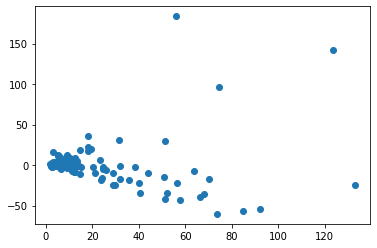

In [123]:
ei = lm_prostate_best.resid
fitted_values = lm_prostate_best.fittedvalues
plt.scatter(fitted_values, ei)

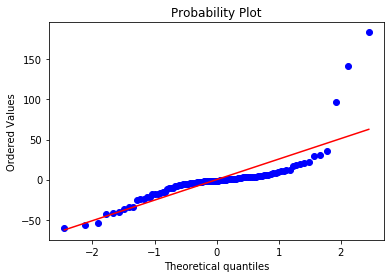

In [124]:
stats.probplot(lm_prostate_best.resid, dist="norm", plot=pylab)
pylab.show()

*Interpretation:*

*Residual Plot:* We can see that the residuals are clustered near the lower values of the fitted Y's. We can also see a few outliers (like case #95, 96, 97).

*Normal QQ plot:* The plot seems to be linear at the center, however, it deviates from linearity at the tails. Thus, it does not conform with the assumptions of normality.

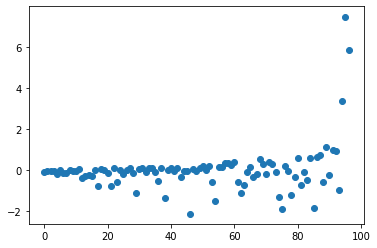

In [125]:
student_del_resids = OLSInfluence(lm_prostate_best).resid_studentized_external
plt.scatter(student_del_resids.index, student_del_resids)

*Interpretation:*

Case #95, 96 and 97 again show up as outliers according to the Studentized Deleted Residuals, along with case #47.

<BarContainer object of 97 artists>

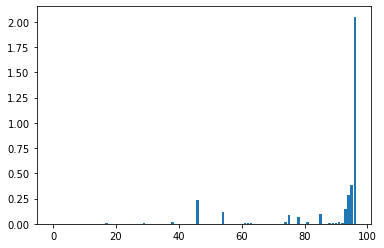

In [126]:
cooks_d = OLSInfluence(lm_prostate_best).summary_frame()["cooks_d"]
plt.bar(cooks_d.index, cooks_d)

*Interpretation:*

Cook's Distance also spots the same cases for the outliers as above (95,96,97 and possibly 47), with case #97 being the biggest influencer compared to the other cases.


*Bonferroni Outlier Test:*

Test value = $t(1-\alpha/2n; n-p-1)$

In [127]:
n = prostate_data.shape[0]
p = len(lm_prostate_best.params)
alpha = 0.05
tTest = stats.t.ppf(1-alpha/(2*n), n-p-1)
tTest

3.5984469542422506

In [128]:
which = np.abs(student_del_resids)>=np.abs(tTest)
which[which==True]

95    True
96    True
dtype: bool

*Interpretation:*

According to the Bonferroni test, we get case # 96 and 97 as the outliers at $\alpha=0.05$.


In [129]:
hii = OLSInfluence(lm_prostate_best).summary_frame()["hat_diag"]
index = hii>2*p/n
index[index==True]

46    True
54    True
75    True
78    True
81    True
85    True
88    True
90    True
93    True
94    True
96    True
Name: hat_diag, dtype: bool

*Interpretation:*

According to just the X values we get the above indices as the outliers. Interestingly, it does not contain case #96.

In [142]:
list(lm_prostate_best.params.index)[1:]

['cancer_volume', 'capsular_penetration']

In [143]:
X_cols = list(lm_prostate_best.params.index)[1:]
X = sm.add_constant(prostate_data[X_cols])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
                index=X.columns)
print(vif)

const                   1.797793
cancer_volume           1.923468
capsular_penetration    1.923468
dtype: float64


/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [145]:
prostate_data[X_cols].corr()

,cancer_volume,capsular_penetration
cancer_volume,1.000000,0.692897
capsular_penetration,0.692897,1.000000


*Interpretation:*

Based on the VIF of the model in cosideration and the correlation matrix above, we see that there exists multi-collinearity in the dataset.

In [146]:
cases = [46,93,94,95,96]
influence_results = OLSInfluence(lm_prostate_best).summary_frame()
influence_results.iloc[cases]

,dfb_Intercept,dfb_cancer_volume,dfb_capsular_penetration,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
46,-0.026745,0.370313,-0.790055,0.237286,-2.069924,0.142473,-0.843717,-2.107474,-0.859022
93,0.306354,-0.612162,0.276323,0.143713,-0.965281,0.316338,-0.656613,-0.964927,-0.656372
94,-0.060697,-0.143983,0.742448,0.282795,3.186114,0.077128,0.921078,3.355480,0.970041
95,-0.139916,0.979119,-0.307648,0.382670,5.933905,0.031574,1.071452,7.463368,1.347619
96,-0.875538,0.250916,1.841731,2.051004,5.016861,0.196444,2.480526,5.831513,2.883321


*Interpretation*

- Looking at the influence measures (DFFITS, Cook's distances, DFBETAS) above, case #96 and 97 have higher influence that the other cases.
- Looking at all the diagnostics so far, we can conclude the case #96 and 97 have greater influence on the overall model compared to the other cases that have shown up as outliers.
